In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple

### MC Droput

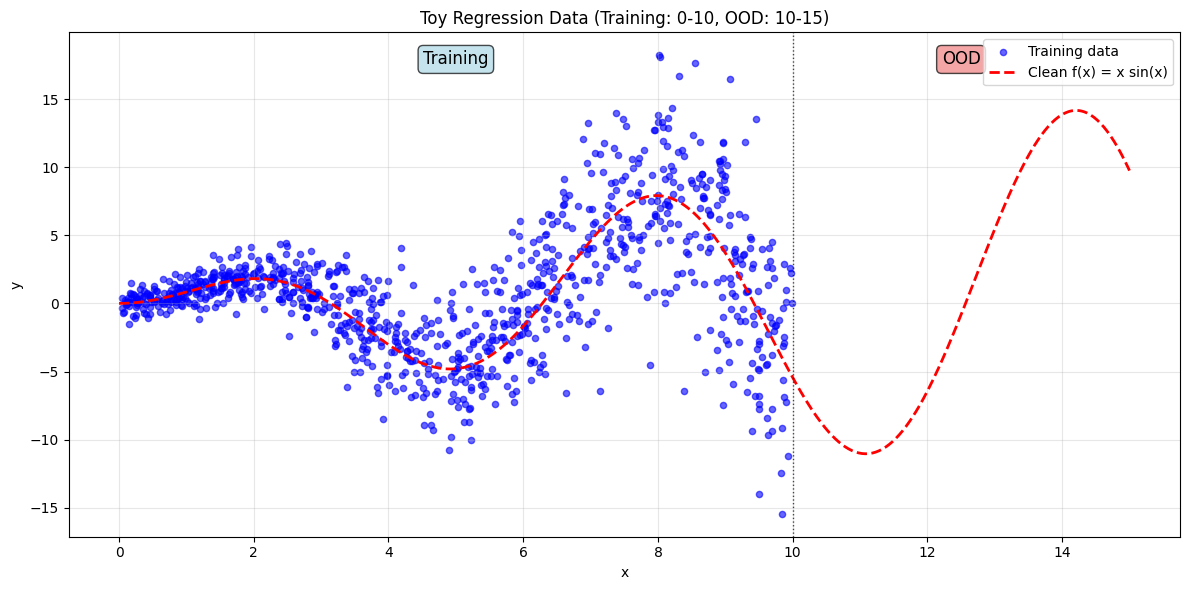

[nll] Epoch 100/700 - avg loss 1.6446
[nll] Epoch 200/700 - avg loss 1.5777
[nll] Epoch 300/700 - avg loss 1.5002
[nll] Epoch 400/700 - avg loss 1.5032
[nll] Epoch 500/700 - avg loss 1.4781
[nll] Epoch 600/700 - avg loss 1.4581
[nll] Epoch 700/700 - avg loss 1.4927


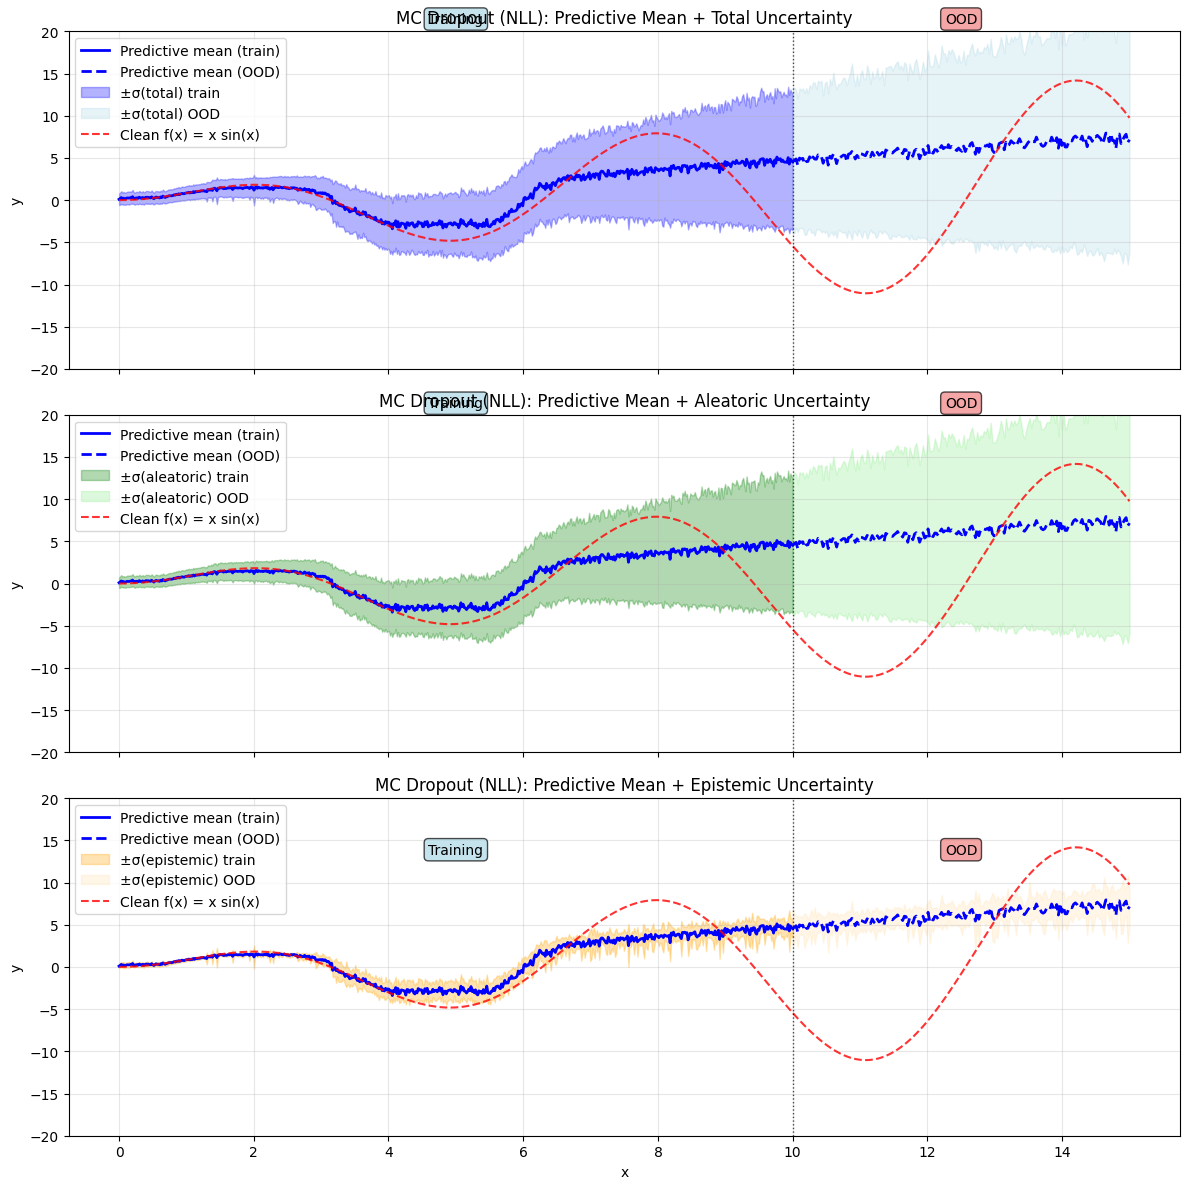

[beta_nll] Epoch 100/700 - avg loss 8.1534
[beta_nll] Epoch 200/700 - avg loss 6.9752
[beta_nll] Epoch 300/700 - avg loss 6.5028
[beta_nll] Epoch 400/700 - avg loss 6.5492
[beta_nll] Epoch 500/700 - avg loss 6.5032
[beta_nll] Epoch 600/700 - avg loss 6.5033
[beta_nll] Epoch 700/700 - avg loss 6.3288


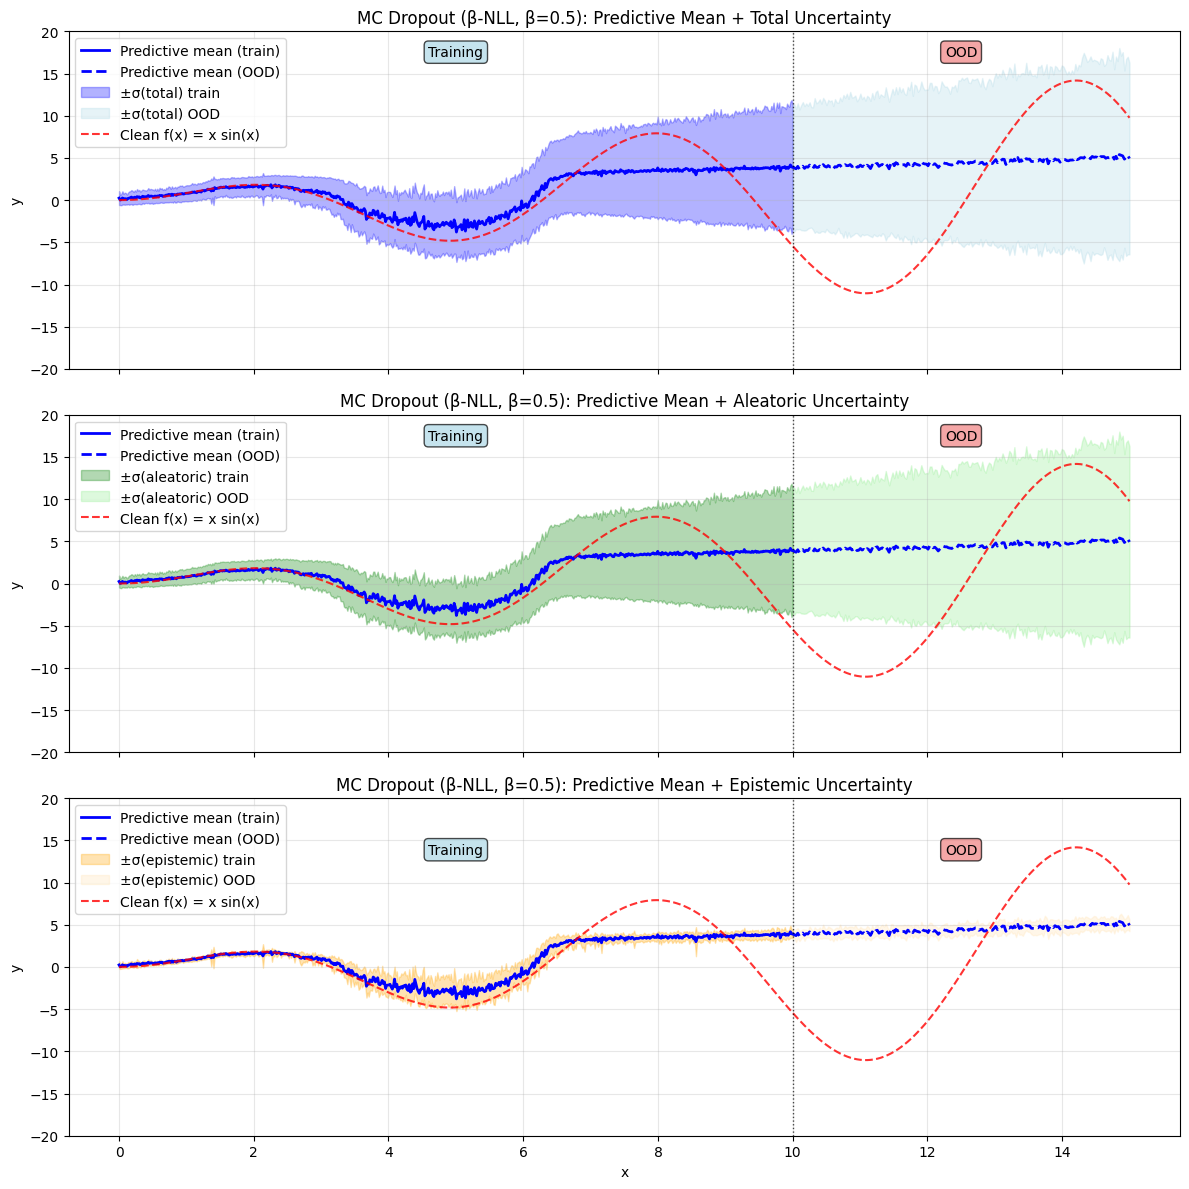

In [2]:
# PyTorch implementation to reproduce Figures 6 and 7 for MC Dropout
# Sinusoidal toy regression with disentangled aleatoric & epistemic uncertainty
# Paper settings: MC-Dropout p=0.25, M=20 forward passes, NLL and β-NLL (β=0.5)
# Architecture from Appendix: two hidden layers (32 units, ReLU) + Dropout; μ head (Linear), σ head (Softplus)
# Training config: 700 epochs, batch size 32, Adam lr=1e-3

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data generation per Section 4.2 -----
# f(x) = x*sin(x) + ε1*x + ε2 ; ε1 ~ N(0,0.3), ε2 ~ N(0,0.3)
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), ood_range=(10.0, 15.0), 
                           grid_points=600, ood_points=200):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    eps1 = np.random.normal(0.0, np.sqrt(0.3), size=(n_train, 1))
    eps2 = np.random.normal(0.0, np.sqrt(0.3), size=(n_train, 1))
    y_train = x_train * np.sin(x_train) + eps1 * x_train + eps2

    # Dense evaluation grid within training range
    x_grid_train = np.linspace(train_range[0], train_range[1], grid_points).reshape(-1, 1)
    y_grid_clean_train = x_grid_train * np.sin(x_grid_train)
    
    # OOD evaluation grid
    x_grid_ood = np.linspace(ood_range[0], ood_range[1], ood_points).reshape(-1, 1)
    y_grid_clean_ood = x_grid_ood * np.sin(x_grid_ood)
    
    # Combine training and OOD grids
    x_grid = np.vstack([x_grid_train, x_grid_ood])
    y_grid_clean = np.vstack([y_grid_clean_train, y_grid_clean_ood])
    
    # Create mask for OOD region
    ood_mask = np.zeros(len(x_grid), dtype=bool)
    ood_mask[grid_points:] = True  # OOD points start after training points

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32), ood_mask)

# ----- Model per Appendix B (Regression) -----
class MCDropoutRegressor(nn.Module):
    def __init__(self, p=0.25):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.mu_head = nn.Linear(32, 1)  # Linear mean
        self.sigma_head = nn.Sequential( # Softplus std; we square to get variance
            nn.Linear(32, 1),
            nn.Softplus()
        )
        self.eps = 1e-6

    def forward(self, x):
        h = self.trunk(x)
        mu = self.mu_head(h)
        sigma = self.sigma_head(h) + self.eps  # std > 0
        var = sigma ** 2
        return mu, var

# ----- Losses (Gaussian NLL and β-NLL with stop-grad on σ²) -----
def gaussian_nll(y, mu, var):
    # LNLL ≈ 0.5*log(σ²) + (y - μ)² / (2σ²)  (constant term omitted)
    return 0.5 * torch.log(var) + (y - mu) ** 2 / (2.0 * var)

def beta_nll(y, mu, var, beta=0.5):
    weight = (var.detach()) ** beta  # stop gradient
    return weight * gaussian_nll(y, mu, var)

# ----- Training loop -----
def train_model(model, loader, epochs=700, lr=1e-3, loss_type='nll', beta=0.5):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            mu, var = model(xb)
            if loss_type == 'nll':
                loss = gaussian_nll(yb, mu, var).mean()
            elif loss_type == 'beta_nll':
                loss = beta_nll(yb, mu, var, beta=beta).mean()
            else:
                raise ValueError("loss_type must be 'nll' or 'beta_nll'")
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        if (epoch + 1) % 100 == 0:
            print(f"[{loss_type}] Epoch {epoch+1}/{epochs} - avg loss {total_loss/len(loader.dataset):.4f}")

# ----- MC-Dropout sampling and uncertainty decomposition -----
def mc_dropout_predict(model, x, M=20):
    # Keep dropout active at inference by using train() but without gradients
    model.train()
    x_t = torch.from_numpy(x).to(device)
    mus = []
    vars_ = []
    with torch.no_grad():
        for _ in range(M):
            mu_i, var_i = model(x_t)
            mus.append(mu_i.cpu().numpy())
            vars_.append(var_i.cpu().numpy())

    mus = np.stack(mus, axis=0).squeeze(-1)   # shape: [M, N]
    vars_ = np.stack(vars_, axis=0).squeeze(-1)  # shape: [M, N]

    mu_pred = mus.mean(axis=0)             # predictive mean μ*
    aleatoric_var = vars_.mean(axis=0)     # E[σ²] (aleatoric)
    epistemic_var = mus.var(axis=0)        # Var[μ] (epistemic)
    total_var = aleatoric_var + epistemic_var

    return mu_pred, aleatoric_var, epistemic_var, total_var

# ----- Plotting -----
def plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data"):
    """Plot the training data and clean function"""
    plt.figure(figsize=(12, 6))
    
    # Plot training data points
    plt.scatter(x_train, y_train, alpha=0.6, s=20, label="Training data", color='blue')
    
    # Plot clean function
    plt.plot(x_grid, y_clean, 'r--', linewidth=2, label="Clean f(x) = x sin(x)")
    
    # Add vertical line to separate training and OOD regions
    plt.axvline(x=10, color='black', linestyle=':', alpha=0.7, linewidth=1)
    plt.text(5, plt.ylim()[1]*0.9, "Training", ha="center", va="center", fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    plt.text(12.5, plt.ylim()[1]*0.9, "OOD", ha="center", va="center", fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_uncertainties(x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, ood_mask, title):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    x = x_grid[:, 0]
    
    # Split data into training and OOD regions
    train_mask = ~ood_mask
    ood_mask_bool = ood_mask
    
    # Plot 1: Predictive mean + Total uncertainty
    axes[0].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[0].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[0].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(tot_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(tot_var[train_mask]), 
                        alpha=0.3, color='blue', label="±σ(total) train")
    axes[0].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(tot_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(tot_var[ood_mask_bool]), 
                        alpha=0.3, color='lightblue', label="±σ(total) OOD")
    axes[0].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"{title}: Predictive Mean + Total Uncertainty")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Predictive mean + Aleatoric uncertainty only
    axes[1].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[1].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[1].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(ale_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(ale_var[train_mask]), 
                        alpha=0.3, color='green', label="±σ(aleatoric) train")
    axes[1].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(ale_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(ale_var[ood_mask_bool]), 
                        alpha=0.3, color='lightgreen', label="±σ(aleatoric) OOD")
    axes[1].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"{title}: Predictive Mean + Aleatoric Uncertainty")
    axes[1].legend(loc="upper left")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Predictive mean + Epistemic uncertainty only
    axes[2].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[2].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[2].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(epi_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(epi_var[train_mask]), 
                        alpha=0.3, color='orange', label="±σ(epistemic) train")
    axes[2].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(epi_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(epi_var[ood_mask_bool]), 
                        alpha=0.3, color='moccasin', label="±σ(epistemic) OOD")
    axes[2].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[2].set_ylabel("y")
    axes[2].set_xlabel("x")
    axes[2].set_title(f"{title}: Predictive Mean + Epistemic Uncertainty")
    axes[2].legend(loc="upper left")
    axes[2].grid(True, alpha=0.3)
    
    # Add vertical line to separate training and OOD regions
    for ax in axes:
        ax.axvline(x=10, color='black', linestyle=':', alpha=0.7, linewidth=1)
        ax.text(5, ax.get_ylim()[1]*0.9, "Training", ha="center", va="center", fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(12.5, ax.get_ylim()[1]*0.9, "OOD", ha="center", va="center", fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        ax.set_ylim(-20, 20)

    plt.tight_layout()
    plt.show()

# ----- Run end-to-end -----
def main():
    # Data
    x_train, y_train, x_grid, y_clean, ood_mask = generate_toy_regression()
    
    # Plot the toy regression data
    plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data (Training: 0-10, OOD: 10-15)")

    # Dataloaders
    ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    loader = DataLoader(ds, batch_size=32, shuffle=True)

    # NLL training and evaluation
    model_nll = MCDropoutRegressor(p=0.25)
    train_model(model_nll, loader, epochs=700, lr=1e-3, loss_type='nll', beta=0.5)
    mu_nll, ale_nll, epi_nll, tot_nll = mc_dropout_predict(model_nll, x_grid, M=20)
    
    plot_uncertainties(x_grid, y_clean, mu_nll, ale_nll, epi_nll, tot_nll, ood_mask, title="MC Dropout (NLL)")

    # β-NLL training and evaluation (β=0.5 per paper)
    model_betanll = MCDropoutRegressor(p=0.25)
    train_model(model_betanll, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
    mu_bnll, ale_bnll, epi_bnll, tot_bnll = mc_dropout_predict(model_betanll, x_grid, M=20)
    plot_uncertainties(x_grid, y_clean, mu_bnll, ale_bnll, epi_bnll, tot_bnll, ood_mask, title="MC Dropout (β-NLL, β=0.5)")

if __name__ == "__main__":
    main()


### Esemble

[nll] Epoch 100/700 - avg loss 1.6107
[nll] Epoch 200/700 - avg loss 1.4635
[nll] Epoch 300/700 - avg loss 1.4450
[nll] Epoch 400/700 - avg loss 1.4172
[nll] Epoch 500/700 - avg loss 1.3822
[nll] Epoch 600/700 - avg loss 1.3476
[nll] Epoch 700/700 - avg loss 1.3288
[nll] Epoch 100/700 - avg loss 1.6555
[nll] Epoch 200/700 - avg loss 1.5511
[nll] Epoch 300/700 - avg loss 1.4996
[nll] Epoch 400/700 - avg loss 1.4994
[nll] Epoch 500/700 - avg loss 1.4959
[nll] Epoch 600/700 - avg loss 1.4917
[nll] Epoch 700/700 - avg loss 1.4752
[nll] Epoch 100/700 - avg loss 1.5404
[nll] Epoch 200/700 - avg loss 1.4804
[nll] Epoch 300/700 - avg loss 1.4591
[nll] Epoch 400/700 - avg loss 1.4389
[nll] Epoch 500/700 - avg loss 1.4206
[nll] Epoch 600/700 - avg loss 1.3978
[nll] Epoch 700/700 - avg loss 1.3862
[nll] Epoch 100/700 - avg loss 1.5029
[nll] Epoch 200/700 - avg loss 1.4875
[nll] Epoch 300/700 - avg loss 1.4556
[nll] Epoch 400/700 - avg loss 1.4174
[nll] Epoch 500/700 - avg loss 1.3435
[nll] Epoch 

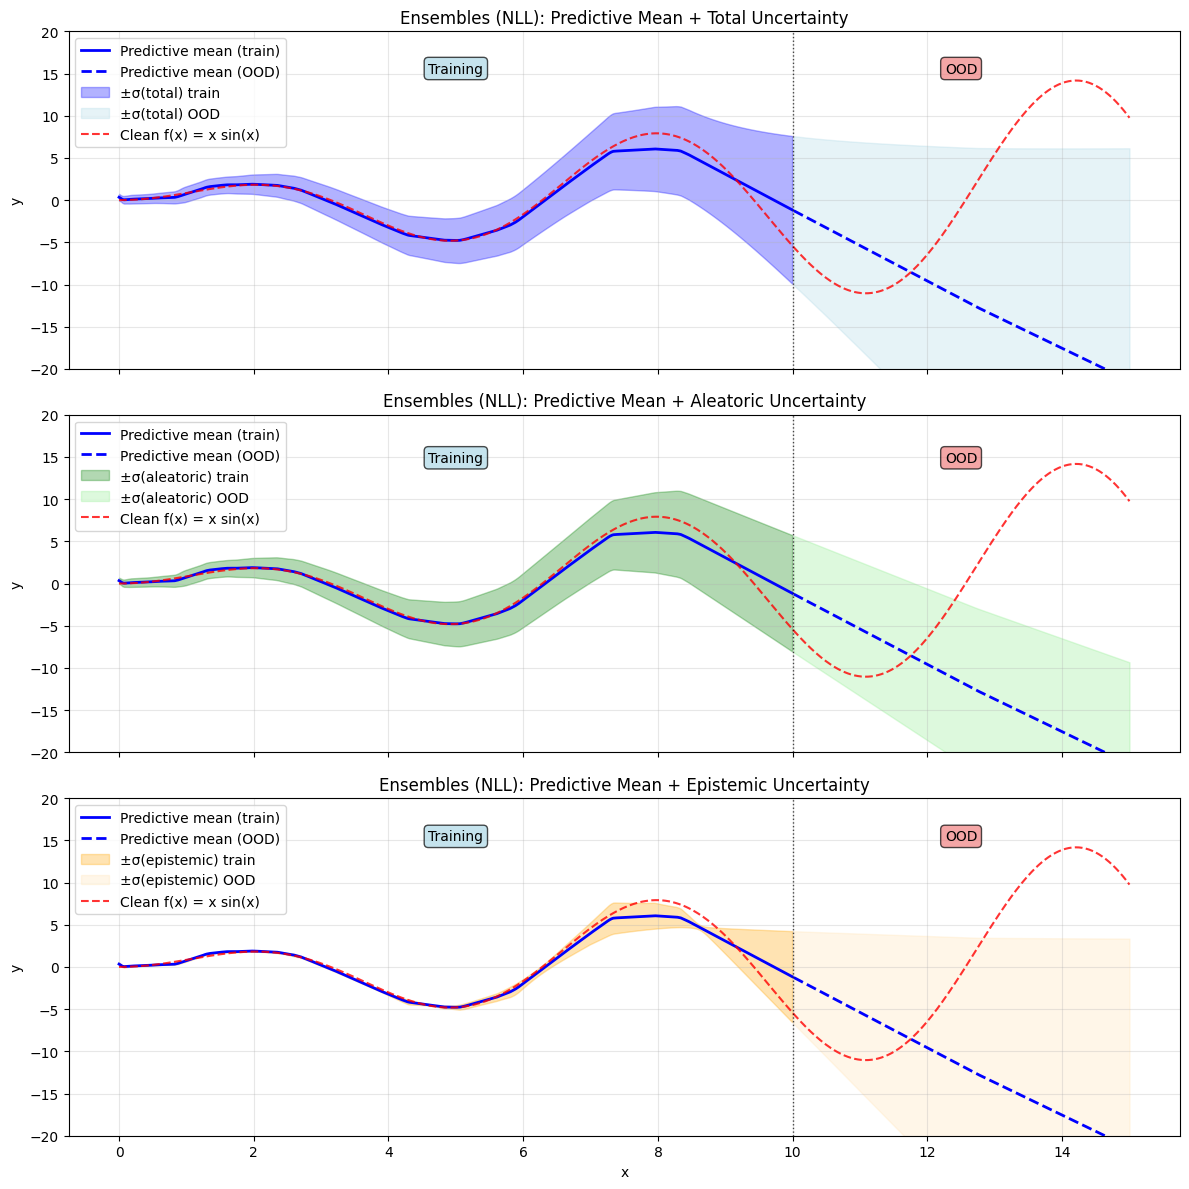

[beta_nll] Epoch 100/700 - avg loss 7.5969
[beta_nll] Epoch 200/700 - avg loss 6.7411
[beta_nll] Epoch 300/700 - avg loss 5.2766
[beta_nll] Epoch 400/700 - avg loss 4.8146
[beta_nll] Epoch 500/700 - avg loss 4.7494
[beta_nll] Epoch 600/700 - avg loss 4.5147
[beta_nll] Epoch 700/700 - avg loss 4.7320
[beta_nll] Epoch 100/700 - avg loss 7.8946
[beta_nll] Epoch 200/700 - avg loss 7.3266
[beta_nll] Epoch 300/700 - avg loss 6.2874
[beta_nll] Epoch 400/700 - avg loss 4.9904
[beta_nll] Epoch 500/700 - avg loss 4.7855
[beta_nll] Epoch 600/700 - avg loss 4.8509
[beta_nll] Epoch 700/700 - avg loss 4.6664
[beta_nll] Epoch 100/700 - avg loss 6.9674
[beta_nll] Epoch 200/700 - avg loss 6.4106
[beta_nll] Epoch 300/700 - avg loss 5.9847
[beta_nll] Epoch 400/700 - avg loss 5.1555
[beta_nll] Epoch 500/700 - avg loss 4.7757
[beta_nll] Epoch 600/700 - avg loss 4.6208
[beta_nll] Epoch 700/700 - avg loss 4.5826
[beta_nll] Epoch 100/700 - avg loss 7.2514
[beta_nll] Epoch 200/700 - avg loss 7.4784
[beta_nll] 

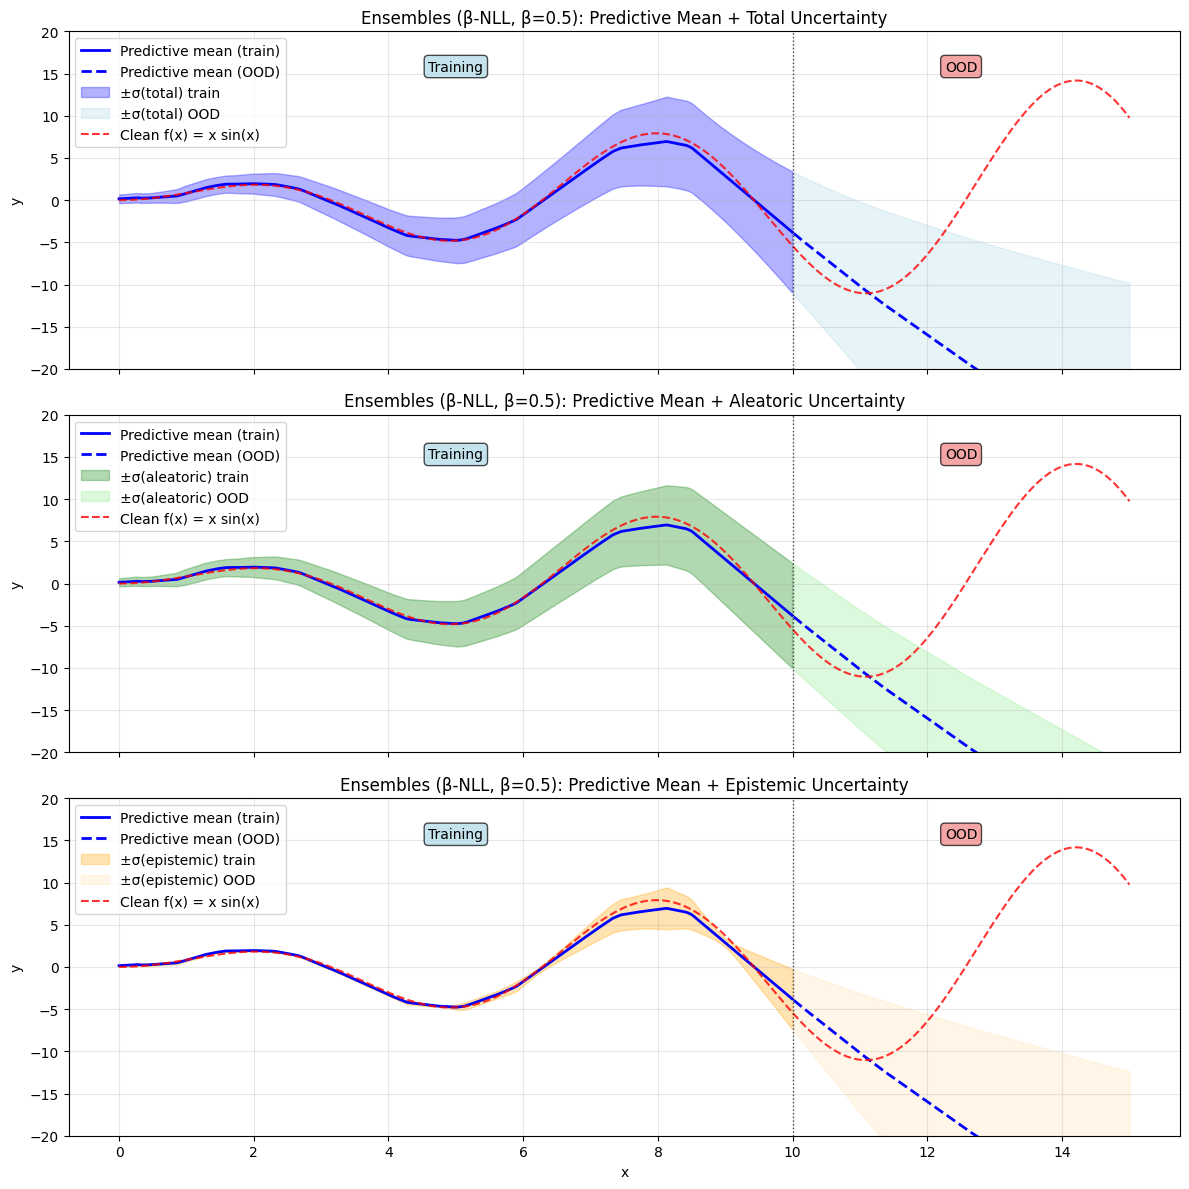

In [4]:
# PyTorch implementation of deep ensembles for toy sinusoidal regression
# Ensemble size = 5, architecture: two hidden layers (32, ReLU), μ head (Linear), σ head (Softplus) per Appendix
# Losses: Gaussian NLL and β-NLL (β=0.5)

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility base (each ensemble member will get a different seed anyway)
base_seed = 123
np.random.seed(base_seed)
torch.manual_seed(base_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data generation per paper (Section 4.2) -----
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), ood_range=(10.0, 15.0), grid_points=600):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    eps1 = np.random.normal(0.0, np.sqrt(0.3), size=(n_train, 1))
    eps2 = np.random.normal(0.0, np.sqrt(0.3), size=(n_train, 1))
    y_train = x_train * np.sin(x_train) + eps1 * x_train + eps2

    x_grid = np.linspace(train_range[0], ood_range[1], grid_points).reshape(-1, 1)
    y_grid_clean = x_grid * np.sin(x_grid)
    ood_mask = (x_grid[:, 0] > train_range[1])

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32), ood_mask)

# ----- Baseline regression model (Appendix B) -----
class BaselineRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.mu_head = nn.Linear(32, 1)       # Linear mean
        self.sigma_head = nn.Sequential(      # Softplus std; variance = sigma^2
            nn.Linear(32, 1),
            nn.Softplus()
        )
        self.eps = 1e-6

    def forward(self, x):
        h = self.trunk(x)
        mu = self.mu_head(h)
        sigma = self.sigma_head(h) + self.eps
        var = sigma ** 2
        return mu, var

# ----- Losses (Gaussian NLL and β-NLL with stop-grad weighting) -----
def gaussian_nll(y, mu, var):
    return 0.5 * torch.log(var) + (y - mu) ** 2 / (2.0 * var)

def beta_nll(y, mu, var, beta=0.5):
    weight = (var.detach()) ** beta  # stop gradient through weight
    return weight * gaussian_nll(y, mu, var)

# ----- Training loop for a single model -----
def train_single(model, loader, epochs=700, lr=1e-3, loss_type='nll', beta=0.5, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            mu, var = model(xb)
            if loss_type == 'nll':
                loss = gaussian_nll(yb, mu, var).mean()
            elif loss_type == 'beta_nll':
                loss = beta_nll(yb, mu, var, beta=beta).mean()
            else:
                raise ValueError("loss_type must be 'nll' or 'beta_nll'")
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        # Optional: print every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"[{loss_type}] Epoch {epoch+1}/{epochs} - avg loss {total_loss/len(loader.dataset):.4f}")

# ----- Train an ensemble of K models -----
def train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='nll', beta=0.5):
    ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

    ensemble = []
    for k in range(K):
        model = BaselineRegressor()
        # Different seed per member to vary initialization and shuffling
        member_seed = base_seed + 1000 + k
        train_single(model, loader, epochs=700, lr=1e-3, loss_type=loss_type, beta=beta, seed=member_seed)
        ensemble.append(model)
    return ensemble

# ----- Ensemble prediction and uncertainty decomposition -----
def ensemble_predict(ensemble, x):
    x_t = torch.from_numpy(x).to(device)
    mus = []
    vars_ = []
    with torch.no_grad():
        for model in ensemble:
            model.eval()  # deterministic
            mu_i, var_i = model(x_t)
            mus.append(mu_i.cpu().numpy())
            vars_.append(var_i.cpu().numpy())

    mus = np.stack(mus, axis=0).squeeze(-1)    # [K, N]
    vars_ = np.stack(vars_, axis=0).squeeze(-1)  # [K, N]

    mu_pred = mus.mean(axis=0)             # predictive mean
    aleatoric_var = vars_.mean(axis=0)     # E[σ²] across ensemble
    epistemic_var = mus.var(axis=0)        # Var[μ] across ensemble
    total_var = aleatoric_var + epistemic_var
    return mu_pred, aleatoric_var, epistemic_var, total_var

# ----- Plotting -----
def plot_uncertainties(x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, ood_mask, title):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    x = x_grid[:, 0]
    
    # Split data into training and OOD regions
    train_mask = ~ood_mask
    ood_mask_bool = ood_mask
    
    # Plot 1: Predictive mean + Total uncertainty
    axes[0].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[0].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[0].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(tot_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(tot_var[train_mask]), 
                        alpha=0.3, color='blue', label="±σ(total) train")
    axes[0].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(tot_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(tot_var[ood_mask_bool]), 
                        alpha=0.3, color='lightblue', label="±σ(total) OOD")
    axes[0].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"{title}: Predictive Mean + Total Uncertainty")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Predictive mean + Aleatoric uncertainty only
    axes[1].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[1].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[1].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(ale_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(ale_var[train_mask]), 
                        alpha=0.3, color='green', label="±σ(aleatoric) train")
    axes[1].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(ale_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(ale_var[ood_mask_bool]), 
                        alpha=0.3, color='lightgreen', label="±σ(aleatoric) OOD")
    axes[1].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"{title}: Predictive Mean + Aleatoric Uncertainty")
    axes[1].legend(loc="upper left")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Predictive mean + Epistemic uncertainty only
    axes[2].plot(x[train_mask], mu_pred[train_mask], 'b-', linewidth=2, label="Predictive mean (train)")
    axes[2].plot(x[ood_mask_bool], mu_pred[ood_mask_bool], 'b--', linewidth=2, label="Predictive mean (OOD)")
    axes[2].fill_between(x[train_mask], mu_pred[train_mask] - np.sqrt(epi_var[train_mask]), 
                        mu_pred[train_mask] + np.sqrt(epi_var[train_mask]), 
                        alpha=0.3, color='orange', label="±σ(epistemic) train")
    axes[2].fill_between(x[ood_mask_bool], mu_pred[ood_mask_bool] - np.sqrt(epi_var[ood_mask_bool]), 
                        mu_pred[ood_mask_bool] + np.sqrt(epi_var[ood_mask_bool]), 
                        alpha=0.3, color='moccasin', label="±σ(epistemic) OOD")
    axes[2].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = x sin(x)")
    axes[2].set_ylabel("y")
    axes[2].set_xlabel("x")
    axes[2].set_title(f"{title}: Predictive Mean + Epistemic Uncertainty")
    axes[2].legend(loc="upper left")
    axes[2].grid(True, alpha=0.3)
    
    # Add vertical line to separate training and OOD regions
    for ax in axes:
        ax.axvline(x=10, color='black', linestyle=':', alpha=0.7, linewidth=1)
        ax.text(5, ax.get_ylim()[1]*0.9, "Training", ha="center", va="center", fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(12.5, ax.get_ylim()[1]*0.9, "OOD", ha="center", va="center", fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        ax.set_ylim(-20, 20)

    plt.tight_layout()
    plt.show()

# ----- Run end-to-end -----
def main():
    # Data
    x_train, y_train, x_grid, y_clean, ood_mask = generate_toy_regression()

    # Train ensemble with NLL
    ens_nll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='nll', beta=0.5)
    mu_nll, ale_nll, epi_nll, tot_nll = ensemble_predict(ens_nll, x_grid)
    plot_uncertainties(x_grid, y_clean, mu_nll, ale_nll, epi_nll, tot_nll, ood_mask, title="Ensembles (NLL)")

    # Train ensemble with β-NLL (β=0.5)
    ens_bnll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='beta_nll', beta=0.5)
    mu_bnll, ale_bnll, epi_bnll, tot_bnll = ensemble_predict(ens_bnll, x_grid)
    plot_uncertainties(x_grid, y_clean, mu_bnll, ale_bnll, epi_bnll, tot_bnll, ood_mask, title="Ensembles (β-NLL, β=0.5)")

if __name__ == "__main__":
    main()
